# **Tasks for a research intern (urban studies)**

**Here I have imported required libraries for this this task requirenments**

In [161]:
import json
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, LineString, shape
import numpy as np

**Here I have taken example data provided on the google drive doc file and created geojson format dataset as named input.geojson file.**

In [162]:
# Define the GeoJSON data
geojson_data = {
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "properties": {"name": "Development area"},
            "geometry": {
                "type": "Polygon",
                "coordinates": [[[37.6173, 55.7558], [37.6179, 55.7565], [37.6185, 55.7559], [37.6173, 55.7558]]]
            }
        },
        {
            "type": "Feature",
            "properties": {"name": "Forest area", "restriction": "no_build"},
            "geometry": {
                "type": "Polygon",
                "coordinates": [[[37.6180, 55.7560], [37.6185, 55.7565], [37.6190, 55.7560], [37.6180, 55.7560]]]
            }
        },
        {
            "type": "Feature",
            "properties": {"name": "Road", "restriction": "no_build"},
            "geometry": {
                "type": "LineString",
                "coordinates": [[37.6175, 55.7555], [37.6185, 55.7555]]
            }
        }
    ]
}

# Write the GeoJSON data to input.json
with open('input.geojson', 'w') as f:
    json.dump(geojson_data, f, indent=4)

print("GeoJSON data has been written to input.json")


GeoJSON data has been written to input.json


**Here I have load and read GeoJson input file which I have created earlier**

In [163]:
# Load GeoJSON input
def load_geojson(file_path):
    with open(file_path) as f:
        data = json.load(f)
    return data

**The extract_features function iterates through the features in a GeoJSON structure, identifies the development area (assumed to be a polygon) and any restricted areas (identified by the "restriction": "no_build" property), converts these area. Here I have taken example data provided on the google drive doc file and Here I have Extracted extra features from the input files Extract features from GeoJSON**

In [164]:
# Extract features from GeoJSON
def extract_features(data):
    development_area = None
    restrictions = []

    # Here I am creating shape accordin to the geometry
    for feature in data['features']:
        if feature['properties'].get('restriction') == 'no_build':
            restrictions.append(shape(feature['geometry']))
        elif feature['geometry']['type'] == 'Polygon':
            development_area = shape(feature['geometry'])

    return development_area, restrictions

**Here I have created a function. I have calculated total area by using area method which calculates thatal area on the basis of longitute and latitute. Then I have developabe area possible by building density multiplying with total area divided by 100. Then I have created a feature list and defined different zoned area by disributing some percentage and multiplied by developable area. Then i distributed each coordinated into fourdiffrent variables to calculate polygon and linestring for each area. I used mathmatical formulae for polygon and line string for calculation. At the end I am appending.**

In [165]:
# Generated building locations based on a grid approach
def generate_zones(development_area, restrictions, building_density):
    # Calculated total area available for development
    total_area = development_area.area
    developable_area = total_area * (building_density / 100)

    # Created a list to store zone geometries
    features = []

    # Defined the area for each type of feature based on the density
    residential_area = developable_area * 0.4  # 40% residential
    commercial_area = developable_area * 0.3   # 30% commercial
    road_area = developable_area * 0.2          # 20% road
    park_area = developable_area * 0.1           # 10% park

    # Created polygons for each zone type (for simplicity, using rectangles)
    x_min, y_min, x_max, y_max = development_area.bounds

    # Residential Zone
    res_polygon = Polygon([(x_min + 0.1 * (x_max - x_min), y_min + 0.1 * (y_max - y_min)),
                           (x_min + 0.1 * (x_max - x_min), y_min + 0.1 * (y_max - y_min) + residential_area),
                           (x_min + 0.1 * (x_max - x_min) + residential_area / (y_max - y_min), y_min + 0.1 * (y_max - y_min) + residential_area),
                           (x_min + 0.1 * (x_max - x_min) + residential_area / (y_max - y_min), y_min + 0.1 * (y_max - y_min))])

    features.append({
        "type": "Feature",
        "properties": {"type": "residential"},
        "geometry": res_polygon.__geo_interface__
    })

    # Commercial Zone
    com_polygon = Polygon([(x_min + 0.1 * (x_max - x_min), y_max - commercial_area),
                           (x_min + 0.1 * (x_max - x_min), y_max),
                           (x_min + 0.1 * (x_max - x_min) + commercial_area / (y_max - y_min), y_max),
                           (x_min + 0.1 * (x_max - x_min) + commercial_area / (y_max - y_min), y_max - commercial_area)])

    features.append({
        "type": "Feature",
        "properties": {"type": "commercial"},
        "geometry": com_polygon.__geo_interface__
    })

    # Road Zone
    road_line = LineString([(x_min, y_min + 0.5 * (y_max - y_min)),
                            (x_max, y_min + 0.5 * (y_max - y_min))])

    features.append({
        "type": "Feature",
        "properties": {"type": "road"},
        "geometry": road_line.__geo_interface__
    })

    # Park Zone
    park_polygon = Polygon([(x_max - park_area / (y_max - y_min), y_max),
                            (x_max, y_max),
                            (x_max, y_max - park_area),
                            (x_max - park_area / (y_max - y_min), y_max - park_area)])

    features.append({
        "type": "Feature",
        "properties": {"type": "park"},
        "geometry": park_polygon.__geo_interface__
    })

    return features

**Here I am writting a function which is creating an output for each feautred and I am parsing previous appended features list.**

In [166]:
# Create GeoJSON output with specified types for features
def create_geojson_output(features):
    output_geojson = {
        "type": "FeatureCollection",
        "features": features
    }

    return output_geojson


**Here I am plotting coordinated using gpd method from geo pandas library.**

In [167]:
# Simplified plotting function
def plot_development_plan(development_area, features):
    # Convert development area to GeoSeries
    development_gdf = gpd.GeoSeries([development_area])

    # Convert features into GeoSeries
    feature_geometries = [shape(feature['geometry']) for feature in features]
    feature_gdf = gpd.GeoSeries(feature_geometries)

    # Plot everything in one figure
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot development area
    development_gdf.plot(ax=ax, color='lightgrey', edgecolor='black', label="Development Area")

    # Plot features
    feature_gdf.plot(ax=ax, alpha=0.7, label="Features", color='blue')

    ax.set_title("Development Plan")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.legend()

    plt.savefig("development_plan_debug.png")  # Save the figure for debugging
    plt.show()


**Here I have written main function and I have written oytput of the features in a single file in geo json format as required in the test. At the end I have called main function with input data file which I have created earlier.**

<ipython-input-167-06ba576048d5>:22: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


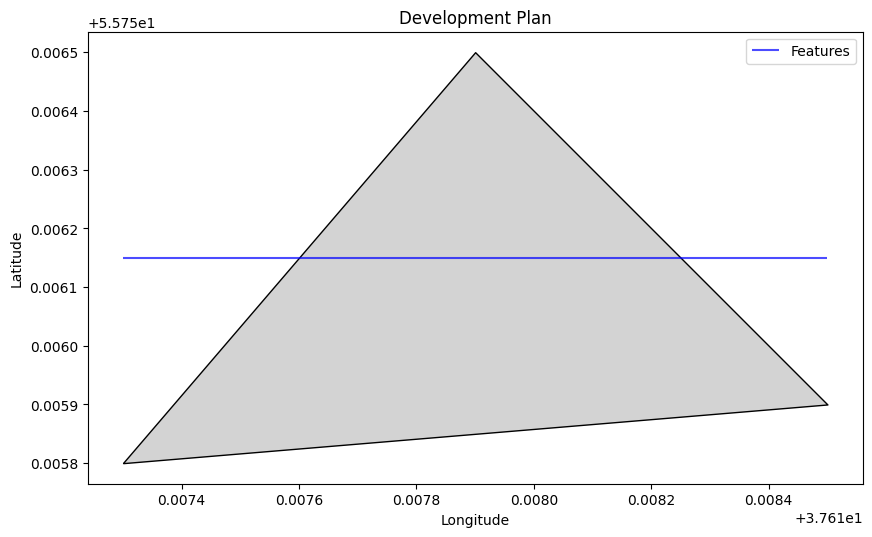

In [168]:
# Main function to run the algorithm
def main(input_file, building_density=30):
    geojson_data = load_geojson(input_file)
    development_area, restrictions = extract_features(geojson_data)

    features = generate_zones(development_area, restrictions, building_density)

    output_geojson = create_geojson_output(features)

    with open('output.geojson', 'w') as f:
        json.dump(output_geojson, f)

    plot_development_plan(development_area, features)

main('input.geojson')

Here I am loading and reading output file which I have created.

In [169]:
# Load GeoJSON output
def load_output_geojson(file_path):
    with open(file_path) as f:
        data = json.load(f)
    return data

load_output_geojson("/content/output.geojson")

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'properties': {'type': 'residential'},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[37.61742, 55.75587],
      [37.61742, 55.7558700468],
      [37.61748685714286, 55.7558700468],
      [37.61748685714286, 55.75587],
      [37.61742, 55.75587]]]}},
  {'type': 'Feature',
   'properties': {'type': 'commercial'},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[37.61742, 55.7564999649],
      [37.61742, 55.7565],
      [37.617470142857144, 55.7565],
      [37.617470142857144, 55.7564999649],
      [37.61742, 55.7564999649]]]}},
  {'type': 'Feature',
   'properties': {'type': 'road'},
   'geometry': {'type': 'LineString',
    'coordinates': [[37.6173, 55.756150000000005],
     [37.6185, 55.756150000000005]]}},
  {'type': 'Feature',
   'properties': {'type': 'park'},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[37.618483285714284, 55.7565],
      [37.6185, 55.7565],
      [37.6185, 55.75649998

In [170]:
!apt-get install -y texlive-xetex texlive-fonts-recommended texlive-latex-extra


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
texlive-fonts-recommended is already the newest version (2021.20220204-1).
texlive-latex-extra is already the newest version (2021.20220204-1).
texlive-xetex is already the newest version (2021.20220204-1).
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


In [171]:
!jupyter nbconvert --to pdf "/content/drive/MyDrive/Colab Notebooks/Tasks for a research intern (urban studies).ipynb"

[NbConvertApp] WARNING | pattern '/content/drive/MyDrive/Colab Notebooks/Tasks for a research intern (urban studies).ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of pro